In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
#step 1导入数据，合并训练集合测试集以备用，我觉得数据处理应该只处理训练集，然后以相同标准处理测试集，这样也便于后面新数据的预测
train=pd.read_csv('E:/data/price/train.csv',index_col=0)
test=pd.read_csv('E:/data/price/test.csv',index_col=0)
all_data=pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)

In [3]:
#step 2数据信息，太长影响视觉，这里先注释掉
# train.info()
#另外，这里有一个列虽然是数值类型（int），但其实表达的是分类，应转为str
train['MSSubClass'] = train['MSSubClass'].astype(str)

In [4]:
#step 3查看缺失数据情况
na_percent=(train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

In [5]:
#step 3.1扔掉缺失率超过0.5的特征
nap=na_percent.to_frame()
train=train.drop(nap[nap>0.5].dropna().index.tolist(),axis=1)  #axis=1 将包含这些列名的列扔掉，注意对测试集做相同处理

In [6]:
#step 3.2将dataframe分为数值部分和数组部分，对两部分分别进行缺值处理
trainnum=train.select_dtypes(include='number')
trainstr=train.drop(trainnum.columns,axis=1)

#接下来利用Imputer进行填充，用Imputer的原因在于他可以提供平均数和众数填充
from sklearn.preprocessing import Imputer
impmean = Imputer(missing_values='NaN', strategy='mean', axis=0)
#对数值部分，用mean填充空值
trainnum.iloc[:,:]=impmean.fit_transform(trainnum)

#对字符部分， 直接get_dummies，将其设为0
# impmode= Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
# impmode.fit_transform(trainstr)
trainstr_dum=pd.get_dummies(trainstr)

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
#step 4将两部分分别进行主要特征提取，数值部分用互信息(先标准化),字符部分sparsepca
#在这之前先把price部分提取出来
price_df=train['SalePrice']
trainnum=trainnum.drop(['SalePrice'],axis=1)
from sklearn import preprocessing
mms=preprocessing.MinMaxScaler()
trainnum.iloc[:,:]=mms.fit_transform(trainnum.values)  

#step 4.1trainnum主要特征提取
import sklearn.metrics 
from sklearn.metrics import normalized_mutual_info_score 
df=pd.DataFrame(index=['score'])
for cl in trainnum.columns:
    df.loc['score',cl]=normalized_mutual_info_score(trainnum[cl],price_df.values)
df_sort=df.sort_values(by='score',axis=1,ascending=False)


trainnum_array=trainnum[df[df>0.3].dropna(axis=1).columns.tolist()]

#step 4.2sparsepca
from sklearn.decomposition import SparsePCA
spca=SparsePCA(n_components=10)
spca.fit(trainstr_dum.values)
trainstr_array=spca.transform(trainstr_dum.values)

In [8]:
# #step 5将两部分合并,注意concat的用法！！pd.concat([df1,df2])
# all_train=pd.concat([trainnum,trainstr_dum],axis=1).reset_index(drop=True)

In [9]:
# #step 6主要特征提取
# import sklearn.metrics 
# from sklearn.metrics import normalized_mutual_info_score 
# df=pd.DataFrame(index=['score'])
# for cl in all_train.columns:
#     df.loc['score',cl]=normalized_mutual_info_score(all_train[cl],price_df.values)
# df_sort=df.sort_values(by='score',axis=1,ascending=False)

In [10]:
#step 5 合并，并生成dataframe备用
all_train=np.concatenate((trainnum_array,trainstr_array),axis=1)
df_train=pd.DataFrame(all_train)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B8057B8>]],
      dtype=object)

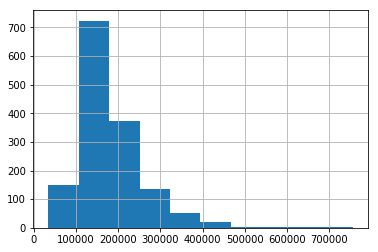

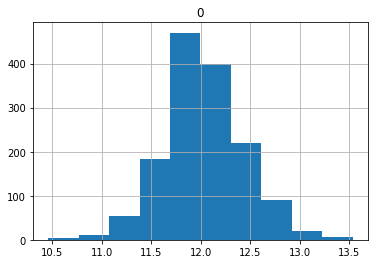

In [17]:
#step 7查看price的分布（更新对数正态分布，将其进行变换，log1p，expm1
price_df.hist()
a=np.log1p(price_df.values)
logp_df=pd.DataFrame(a)
logp_df.hist()

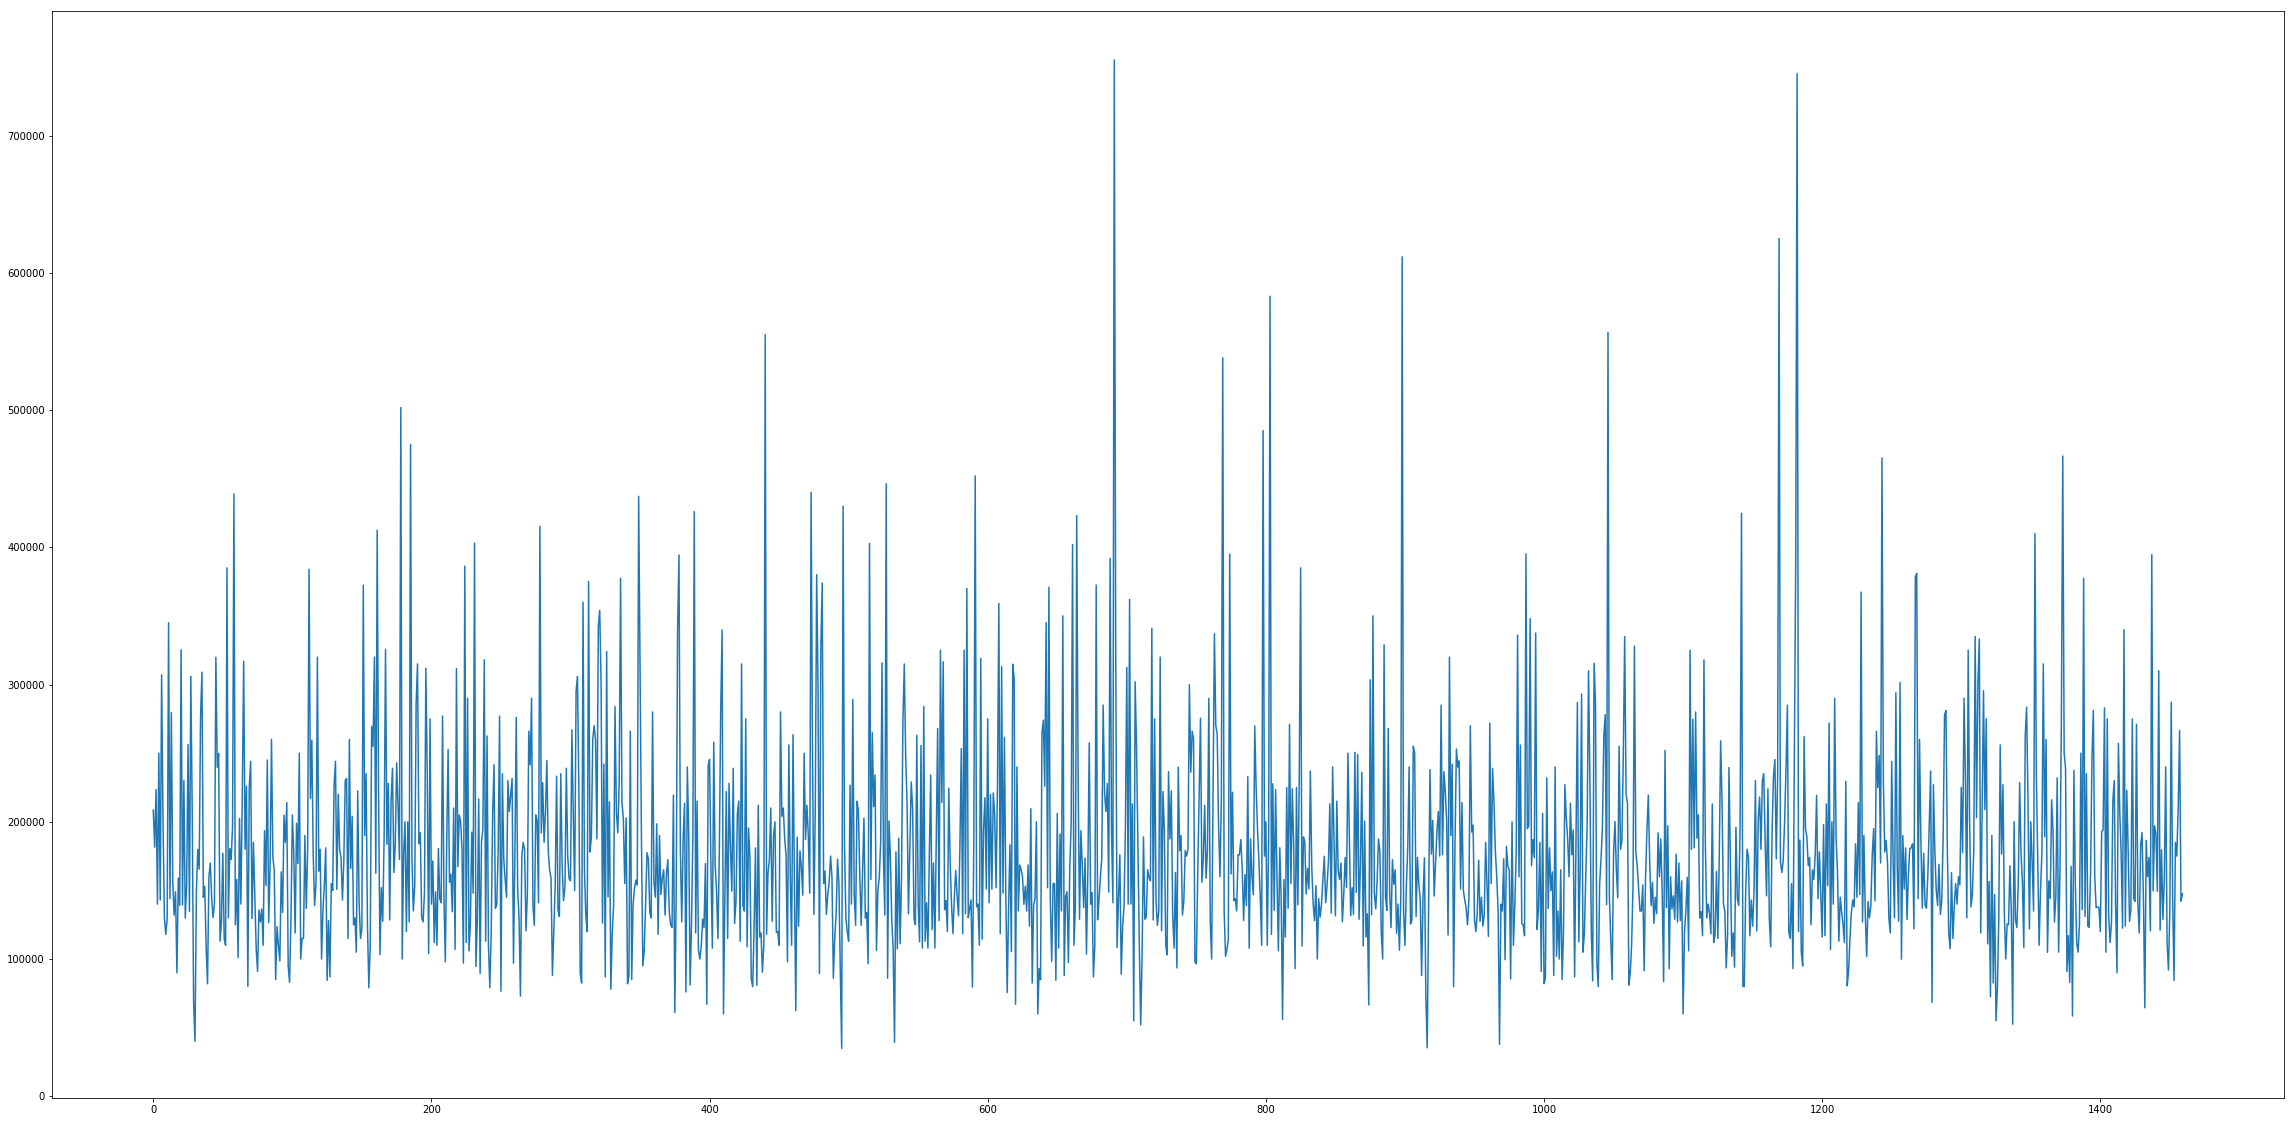

In [21]:
plt.figure(figsize=(40,20))
plt.plot(price_df.values)
plt.show()

In [24]:
#先用一个简单的模型试验一下
from sklearn.ensemble import RandomForestRegressor
clfrf=RandomForestRegressor(n_estimators=25)
clfrf.fit(all_train,price_df.values)
predictionrf=clfrf.predict(all_train)
rate=abs(predictionrf-price_df.values)/price_df.values
np.mean(rate)

0.0419015735475603

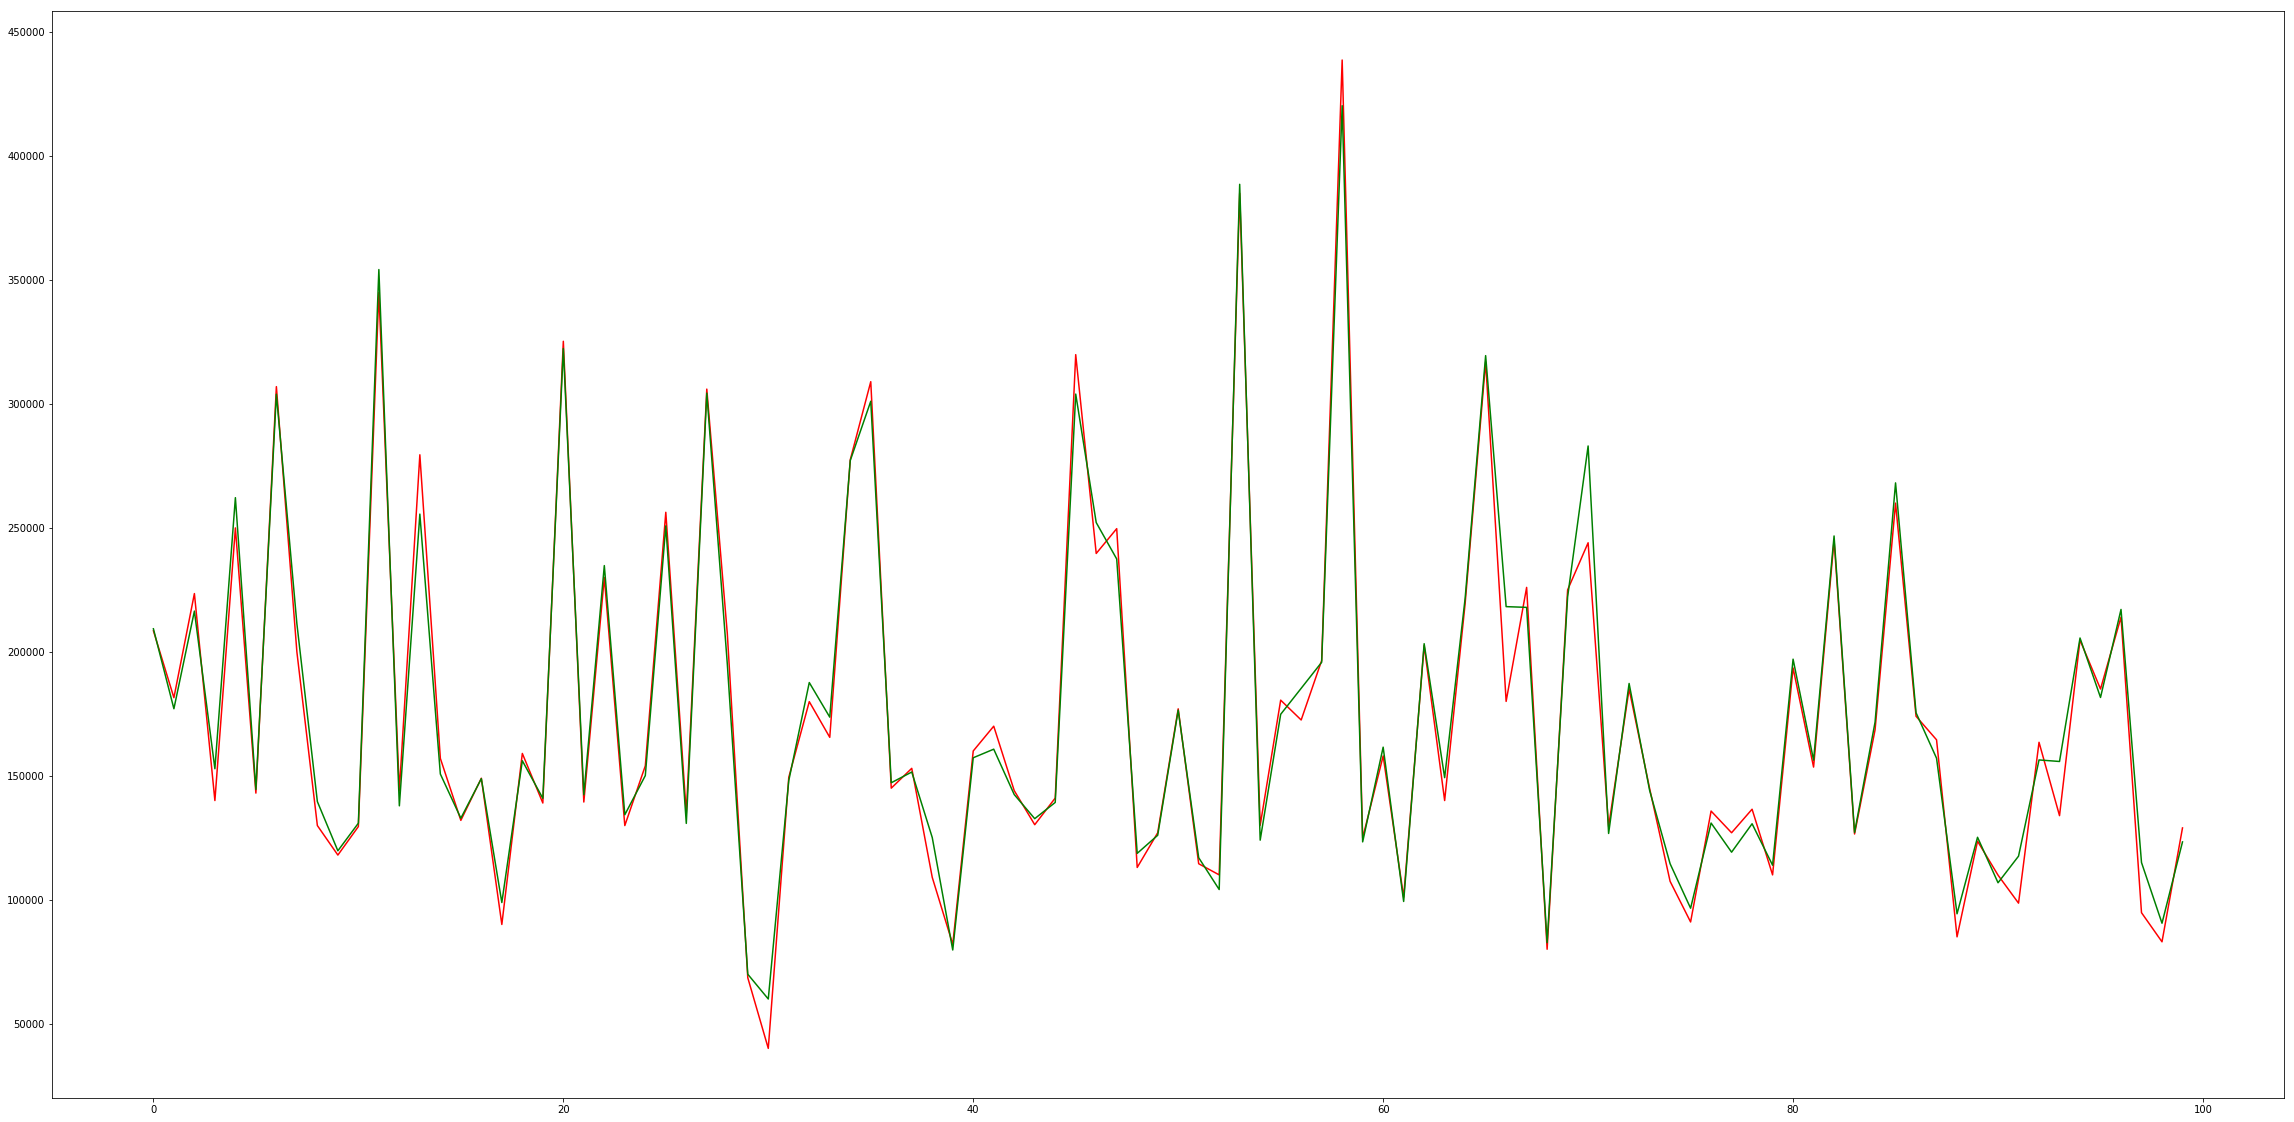

In [27]:
plt.figure(figsize=(40,20))
plt.plot(price_df.values[:100],color='red')
plt.plot(predictionrf[:100],color='green')
plt.show()

In [35]:
trainnum_array

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold
Id,,,,,,,,,,,,,,,,,,,
1,0.150685,0.033420,0.666667,0.949275,0.883333,0.122500,0.125089,0.064212,0.140098,0.119780,0.413559,0.259231,0.500000,0.936364,0.386460,0.000000,0.111517,0.000000,0.090909
2,0.202055,0.038795,0.555556,0.753623,0.433333,0.000000,0.173281,0.121575,0.206547,0.212942,0.000000,0.174830,0.333333,0.690909,0.324401,0.347725,0.000000,0.000000,0.363636
3,0.160959,0.046507,0.666667,0.934783,0.866667,0.101250,0.086109,0.185788,0.150573,0.134465,0.419370,0.273549,0.333333,0.918182,0.428773,0.000000,0.076782,0.000000,0.727273
4,0.133562,0.038561,0.666667,0.311594,0.333333,0.000000,0.038271,0.231164,0.123732,0.143873,0.366102,0.260550,0.416667,0.890909,0.452750,0.000000,0.063985,0.492754,0.090909
5,0.215753,0.060576,0.777778,0.927536,0.833333,0.218750,0.116052,0.209760,0.187398,0.186095,0.509927,0.351168,0.583333,0.909091,0.589563,0.224037,0.153565,0.000000,1.000000
6,0.219178,0.059899,0.444444,0.876812,0.750000,0.000000,0.129695,0.027397,0.130278,0.106012,0.274092,0.193670,0.250000,0.845455,0.338505,0.046674,0.054845,0.000000,0.818182
7,0.184932,0.041057,0.777778,0.956522,0.916667,0.116250,0.242558,0.135702,0.275941,0.312070,0.000000,0.256217,0.416667,0.945455,0.448519,0.297550,0.104205,0.000000,0.636364
8,0.167979,0.042450,0.666667,0.731884,0.383333,0.150000,0.152197,0.092466,0.181178,0.177375,0.476029,0.330821,0.416667,0.663636,0.341326,0.274212,0.372943,0.413043,0.909091
9,0.102740,0.022529,0.666667,0.427536,0.000000,0.000000,0.000000,0.407534,0.155810,0.157871,0.364165,0.271289,0.500000,0.281818,0.330042,0.105018,0.000000,0.371377,0.272727
